# **Real Estate: It's Ame-azing!**
### *A report on predicting the sales price of houses in Ames, Iowa.*
| | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|Emily K. Sanders| | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |Project 2: Ames Housing Prices|
|DSB-318| | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |April 19, 2024|
---

## Problem Statement

The housing market in Ames, Iowa is [small but competitive](https://www.redfin.com/city/477/IA/Ames/housing-market), and houses often go quickly (Redfin, 2024).  In such a market, realtors and their clients can gain advantage by correctly estimating how much a house will sell for, whether the client is buying or selling.  In this report, I will produce and explain a model that realtors can use to make this estimate.  As a secondary goal, I will look for elements of a house that contribute greatly to its value, to give sellers some ideas of how to improve their home's resale value.

### Deliverables

- **A model calibrated to predict home sale prices.**  I will assess the quality of this model primarily through *R-squared*, a measure of how much of the variability in home prices it can predict, and *Root Mean Square Error* (RMSE), a measure of how far, in dollars, the model's predictions tend to be from reality.  It is unfortunately not possible to create a model with no error.
- **Recommendations to sellers on which elements of their homes to invest in.**  Although it is not possible to establish cause and effect through observational research such as presented here, I will draw the best conclusions I can from the interpretation of my models.  

## Method

In this report, I will use the Python programming language and relevant modules to develop and test linear models to predict the price a house will sell for based on its characteristics.  I intend to fit at least one ordinary least-squares, one Ridge, and one LASSO regression model, and iteratively improve them until they can explain a sufficient portion of the overall variance in home prices, and/or sufficiently minimize the average distance between the model's predictions and the actual sale prices in the dataset, whichever is practicable.  Furthermore, I intend to create at least one model with a particular eye towards interpretation - that is, sacrificing predictive power if necessary in order to draw insights about the drivers of home prices.  Although it is impossible to say at the outset of such a project how successful it will be (as they say, one cannot get $R^2$ from a stone, or something to that effect), I am optimistic that I will be able to produce a model my clients will find useful when working with their clients, helping the realtors of Ames to thrive in their careers, and the people they serve to find happy homes.

### Apparatus

The analyses presented in this report were conducted in Python, and made use of the Pandas, Numpy, Matplotlib, Seaborn, Scipy, and Scikit-Learn modules.  The developers of these programs have graciously made them open source.

In [329]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn import metrics

### Dataset

The data for this project were [provided by the commissioners](https://www.kaggle.com/competitions/318-ames-competition/leaderboard) of the project.  It originates from the records of the City Assessor's Office in Ames, Iowa ([de Cock, 2011](https://jse.amstat.org/v19n3/decock.pdf)).  It contains information on 2051 home sales in Ames from 2006 and 2010.  Because of the large time gap between 2010 and the present day, I strongly advise my realtor clients to exercise caution when using my models.  As they surely know better than I, the housing market has changed dramatically in the past decade and a half.  However, a dataset in the hand is worth two in the tree, and this dataset is, I discovered, of unusually high quality.  It contains 78 columns describing each house, as well as two identification numbers and, most importantly, the price for which the house was sold, making for nearly 160,000 individual data points.  Although initial inspection revealed 11,040 of these values to be missing, further investigation revealed that all but 330 of these were simply inconveniently formatted, not true black holes of information.  (The remaining 330 were filled with [simple imputation](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html); see [Data Preparation](#Data-Preparation) for more details.)

Among these columns were facts and figures such as the home's age, materials, and square footage, along with subjective (albeit admirably operationalized) rankings of its quality and condition.  Basements, garages, and bathrooms are extensively detailed, and some of each house's personal charm shines through the descriptions of their pools, masonry, fireplaces, and more.  Additionally, although the data do not include specific addresses, each house is assigned to a neighborhood within Ames, and given a score based on its proximity to major roads or train stations.  If this amount of information was good enough for the City Assessor's office, it is surely good enough for my purposes too.

In [331]:
# Read in the datasets.
housing = pd.read_csv('./datasets/train.csv')

In [332]:
# Because these datasets are large, change the settings to show them.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Data Preparation

The Ames dataset provides information on the characteristics and sales prices of 2051 houses.  These data can be used to make predictions and draw inferences about how much other, similar houses in Ames are likely to sell for.  By modeling sales price as a function of the homes' elements I aim to produce one or more high-quality model(s) for my clients, Ames realtors, to use with their clients, home buyers and sellers, to help them make informed real estate decisions.  My primary goal is to create a model that generates realistic predictions so that realtors and their clients can keep ahead of bidding wars and capitalize on good deals, and my secondary goal is to create a model that offers insight into what drives home prices, and how homeowners can best invest in their homes prior to selling.  Below are some preliminary statistics on the dataset as it was obtained, followed by a discussion of how I prepared it for modeling.

In [333]:
# Get the dimensions of the data.
housing.shape

(2051, 81)

In [334]:
# Show the first few rows of the data.
housing.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,NaN,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [335]:
# Get sample statistics for the data.
housing.describe(include = 'all')

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
count,2051.000000,2.051000e+03,2051.000000,2051,1721.000000,2051.000000,2051,140,2051,2051,2051,2051,2051,2051,2051,2051,2051,2051,2051.000000,2051.000000,2051.000000,2051.000000,2051,2051,2051,2051,811,2029.000000,2051,2051,2051,1996,1996,1993,1996,2050.000000,1995,2050.000000,2050.000000,2050.000000,2051,2051,2051,2051,2051.000000,2051.000000,2051.000000,2051.000000,2049.000000,2049.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051,2051.000000,2051,2051.000000,1051,1938,1937.000000,1937,2050.000000,2050.000000,1937,1937,2051,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,9,400,65,2051.000000,2051.000000,2051.000000,2051,2051.000000
unique,NaN,NaN,NaN,7,NaN,NaN,2,2,4,4,3,5,3,28,9,8,5,8,NaN,NaN,NaN,NaN,6,6,15,15,3,NaN,4,5,6,5,5,4,6,NaN,6,NaN,NaN,NaN,5,5,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,8,NaN,5,6,NaN,3,NaN,NaN,5,5,3,NaN,NaN,NaN,NaN,NaN,NaN,4,4,5,NaN,NaN,NaN,9,NaN
top,NaN,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,BrkFace,NaN,TA,TA,PConc,TA,TA,No,GLQ,NaN,Unf,NaN,NaN,NaN,GasA,Ex,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,Gd,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,NaN
freq,NaN,NaN,NaN,1598,NaN,NaN,2044,85,1295,1843,2049,1503,1953,310,1767,2025,1700,1059,NaN,NaN,NaN,NaN,1619,2025,724,721,630,NaN,1247,1778,926,887,1834,1339,615,NaN,1749,NaN,NaN,NaN,2018,1065,1910,1868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1047,NaN,1915,NaN,523,1213,NaN,849,NaN,NaN,1832,1868,1861,NaN,NaN,NaN,NaN,NaN,NaN,4,227,56,NaN,NaN,NaN,1781,NaN
mean,1474.033642,7.135900e+08,57.008776,NaN,69.055200,10065.208191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.112140,5.562165,1971.708922,1984.190151,NaN,NaN,NaN,NaN,NaN,99.695909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,442.300488,NaN,47.959024,567.728293,1057.987805,NaN,NaN,NaN,NaN,1164.488055,329.329108,5.512921,1499.330083,0.427526,0.063446,1.577279,0.371039,2.843491,1.042906,NaN,6.435885,NaN,0.590931,NaN,NaN,1978.707796,NaN,1.776585,473.671707,NaN,NaN,NaN,93.833740,47.556802,22.571916,2.591419,16.511458,2.397855,NaN,NaN,NaN,51.574354,6.219893,2007.775719,NaN,181469.701609
std,843.980841,1.886918e+08,42.824223,NaN,23.260653,6742.488909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.426271,1.104497,30.177889,21.036250,NaN,NaN,NaN,NaN,NaN,174.963129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,461.204124,NaN,165.000901,444.954786,449.410704,NaN,NaN,NaN,NaN,396.446923,425.671046,51.068870,500.447829,0.522673,0.251705,0.549279,0.501043,0.826618,0.209790,NaN,1.560225,NaN,0.638516,NaN,NaN,25.441094,NaN,0.764537,215.934561,NaN,NaN,NaN,128.549416,66.747241,59.845110,25.229615,57.374204,37.782570,NaN,NaN,NaN,573.393985,2.744736,1.312014,NaN,79258.659352
min,1.000000,5.263011e+08,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,334.000000,0.00000

Keen readers may notice some troubling signs in these summary statistics.  The *counts* row indicates missing data in a number of columns, and the columns for above-ground full bathrooms, half bathrooms, bedrooms, and kitchens each list a minimum value of 0, which seems unlikely.  Many of the columns represent categorical data, stored as strings, which will have to be converted to numeric representatives before it can be used in the model.  Several of the columns that are already encoded as numbers also represent categorical data, and will have to be encoded to avoid improper mathematical operations (e.g., taking the average of zoning classes).  Elsewhere in this report, I have described the steps I took to resolve these issues, as well as others discovered along the way.

Below, I plotted the distribution of the sale prices.

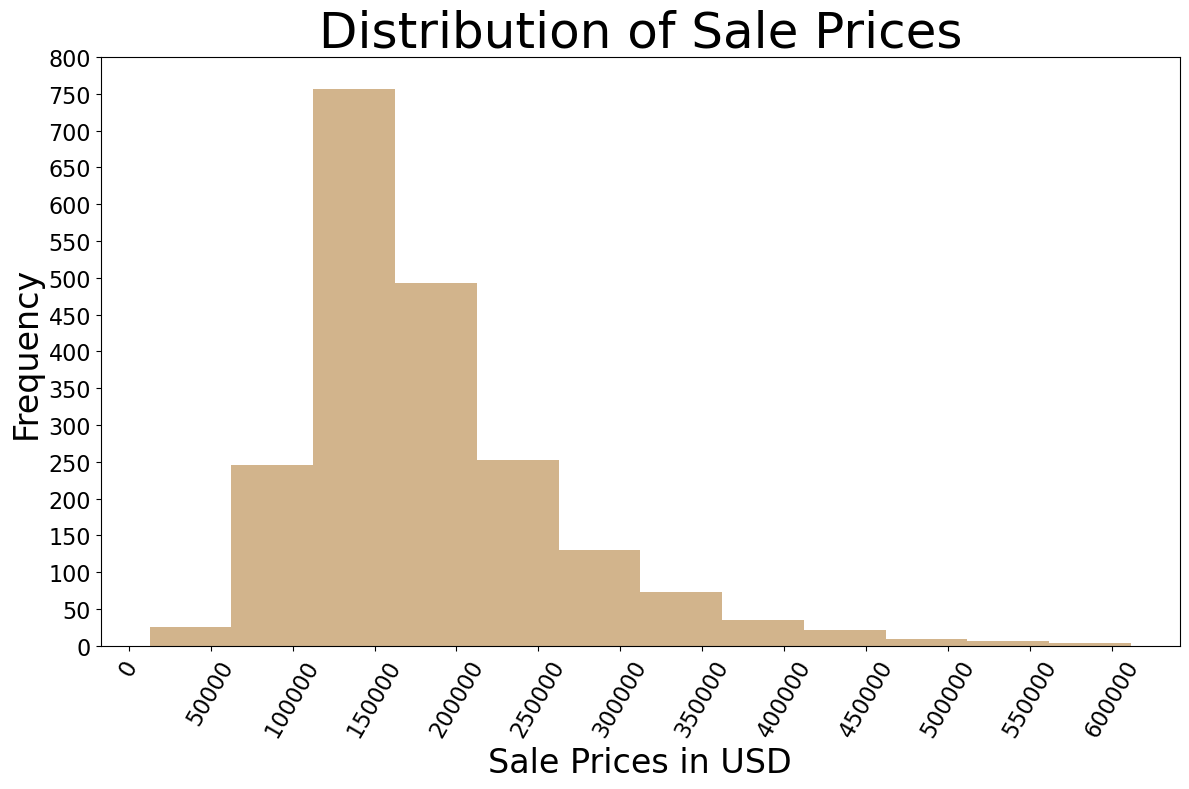

In [336]:
plt.figure(figsize = (12, 8))
plt.hist(housing['SalePrice'], bins = 12, color = 'tan');
plt.title('Distribution of Sale Prices', size = 36)
plt.xlabel('Sale Prices in USD', size = 24);
plt.ylabel('Frequency', size = 24);
plt.xticks(ticks = list(range(0, 600_001, 50_000)), size = 16, rotation = 60)
plt.yticks(ticks = list(range(0, 801, 50)), size = 16)
plt.tight_layout()
plt.savefig('./images/sale-price-histogram.png')

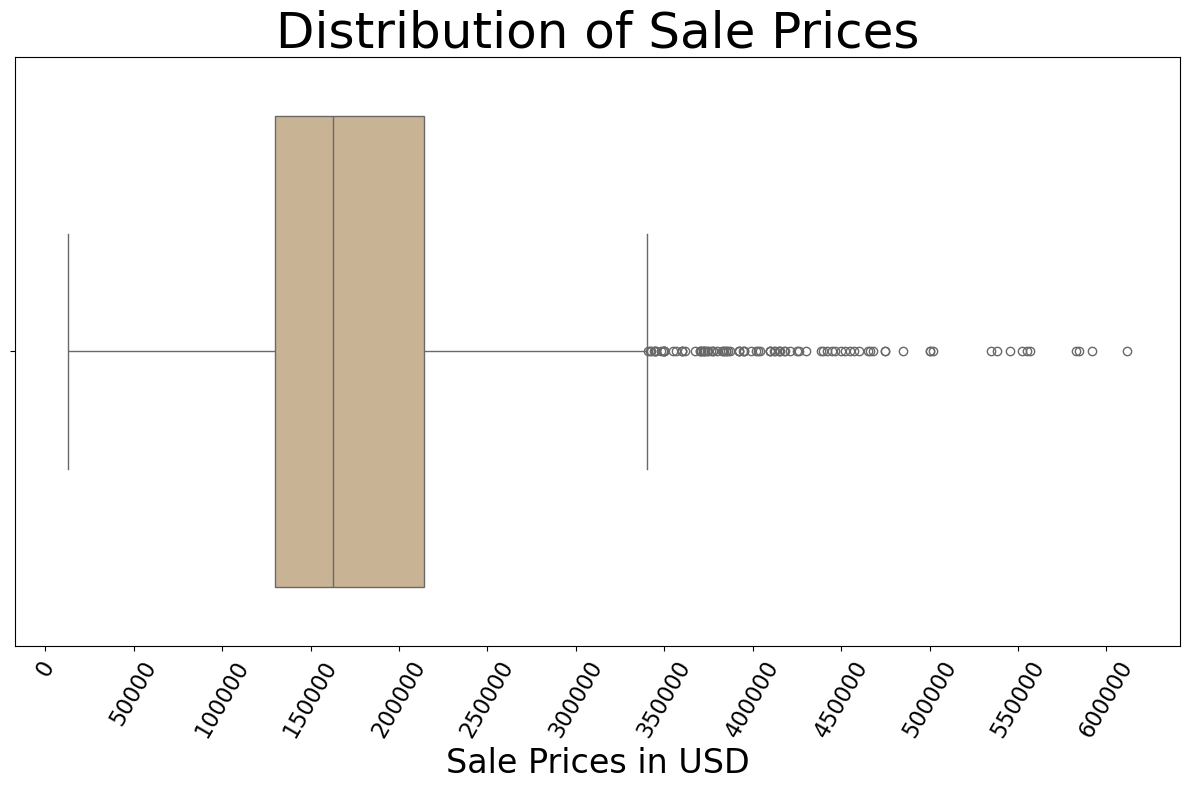

In [337]:
plt.figure(figsize = (12, 8))
sns.boxplot(data = housing['SalePrice'], color = 'tan', orient = 'h')
plt.title('Distribution of Sale Prices', size = 36)
plt.xlabel('Sale Prices in USD', size = 24);
#plt.ylabel('Frequency', size = 24);
plt.xticks(ticks = list(range(0, 600_001, 50_000)), size = 16, rotation = 60)
#plt.yticks(ticks = list(range(0, 801, 50)), size = 16)
plt.tight_layout()
plt.savefig('./images/sale-price-boxpot.png')

As these graphs show, the target variable, sale price, does not follow a normal distribution particularly closely.  Linear models can often perform relatively well even if the taget variable is not normally distributed, but it is less than ideal. Outliers can dramatically influence the mean, giving them undue "pull" in linear models.  Furthermore, the sparsity of values in higher price ranges relative to others means the models will get more "practice," so to speak, identifying low- to mid-priced homes as compared with high-priced homes.  Overall, based on these charts, my advice to my clients is to take extra care when using the model(s) I create to make predictions or draw conclusions about houses estimated to sell for over about \$325,000.  Be more vigilant when advising buyers about how much they can expect to have to pay, and be more conservative when advising sellers on how much they can expect to get or by how much they can improve their price with my recommended investment projects.

#### Renaming Columns

As shown above, many of the column names in this data set contain spaces, begin with numbers, or otherwise violate python naming conventions, and/or are not immediately semantically clear.  To resolve these issues, I renamed the columns.

These changes were applied to all of the data, prior to the train/test split.  However, becaue this change only applies to the structure of the dataframe, and not to the data within, it can be easily applied to novel data and does not contaminate the testing portion of the data.

In [338]:
# Change all column names
housing.columns = housing.columns.str.lower().str.replace(' ', '_')
housing.columns = housing.columns.str.replace('bsmt', 'basemt')

# Change specific column names
col_dict = {'ms_subclass': 'building_type', 'ms_zoning': 'zoning', 'utilities': 'utilities_type', 
            'condition_1': 'prox_to_road_rr_1', 'condition_2': 'prox_to_road_rr_2', 
            'year_remod/add': 'year_remodel_add', 'roof_matl': 'roof_material', 
            'exterior_1st': 'exterior_1', 'exterior_2nd': 'exterior_2', 'mo_sold': 'month_sold', 
            'mas_vnr_type': 'masonry_type', 'mas_vnr_area': 'masonry_area', 
            'basemtfin_type_1': 'basemt_fin_1_qual', 'basemtfin_type_2': 'basemt_fin_2_qual', 
            'basemtfin_sf_1': 'basemt_fin_1_sf', 'basemtfin_sf_2': 'basemt_fin_2_sf', 
            'total_basemt_sf': 'basemt_total_sf', '1st_flr_sf': 'floor_1_sf', 
            '2nd_flr_sf': 'floor_2_sf', 'totrms_abvgrd': 'total_rms_abv_grd', 
            'functional': 'home_functionality', 'enclosed_porch': 'encl_porch_sf', 
            '3ssn_porch': 'three_season_porch_sf', 'screen_porch': 'screen_porch_sf'}
housing.rename(columns = col_dict, inplace = True)

# View column names
# This code is commented out because it's long.
#housing.columns

A dictionary of what these columns names mean is available in the [readme](README.md).  Note that many descriptive variables were later "dummy"-coded, meaning they were expanded from one column containing many values to several columns, each representing just of those values, and filled with 0s and 1s to indicate that value's applicability to each row.  For example, the single column *lot_slope*, with values "gentle," "moderate," or "severe," became 2 columns: *land_slope_mod* and *land_slope_sev*. (What would have been *land_slope_gentle* became the baseline to which the other two are compared.)  Nonetheless, the meaning of these columns, where they appear, can still easily deduced from the names and listed levels of the variables as they originally appeared.

#### Null and Invalid Values

Missing values can bring a model to a halt, and incorrect values can severely curtail its functionality.  It is essential for any model to have methods in place to handle such values, and for the future realtors who will use this model, it is essential that those methods run smoothly and without any need for them to manually clean the data.

However, because null and invalid values can appear anywhere in real-world data and present a seemingly infinite number of dilemmas, I did not want to waste any opportunities to familiarize myself with the most common "weak points" of the City Assessor's records.  Therefore, I conducted a thorough, often manual, examination of all null and suspicious values prior to the train/test split.  Through this process, I developed generalizable rules that can be applied to future data sight-unseen.

Additionally, in the interest of creating a model that does not require much, if any, manual preprocessing from my clients, I opted not to drop any of the sale price outliers discussed above.  They may well have a negative effect on the usefulness of the model, but in my best professional judgment, the risk of diminished usefulness is outweighed by the risk of dimished *use*.  If the model I return requires extensive work or specialized knowledge on the front end, then its predictive power on the back end is less likely to even see the light of day.

The future-facing cleaning rules are presented below, with brief commentary.  For a detailed discussion of my investigation, see [Appendix A](./Appendix-A--Missing-and-Invalid-Value-Explorations.ipynb).

The dataset as received contained 11,040 missing values over 26 columns.  Code is presented below to generate this report, or a table is available in [Appendix A](./Appendix-A--Missing-and-Invalid-Value-Explorations.ipynb).  Many of these columns were noted in the [received data dictionary](https://www.kaggle.com/competitions/318-ames-competition/data) to use missing values to indicate the lack of an element, meaning that these values were not necessarily defective, but may have been correctly encoded in an inconvenient way.  After my investigation, I deemed this to be the case for all but 330 of these missing values.  Those 330 values, all in the column for lot frontage, were imputed in a later step.

In [339]:
# Total missing values
housing.isnull().sum().sum()

11040

In [340]:
# Missing values by column, filtered to only columns with at least 1 NA
# This code is commented out because the output is long. Curious readers can uncomment and run it.
# nas = housing.isnull().sum().sort_values(ascending = False)
# nas[nas>0]

As detailed in [Appendix A](Appendix-A--Missing-and-Invalid-Value-Explorations.ipynb), a large proportion of the missing values were in columns related to basement characteristics.  After a thorough investigation, I concluded that most of these missing values corresponded to houses that simply did not have basements.  Therefore, I filled these missing values in numeric columns with 0, and in object columns with "not-present," to be dummy coded later.  The only notable exception I discovered was in the column representing basement exposure (e.g., windows or a walkout), which contained several missing values in rows that otherwise clearly indicated the presence of a basement.  In this situation, I recoded those values to "No," a level pre-defined for the column (see [readme.md](README.md)).

In [341]:
# Create a mask to find houses that probably have no basements
no_basemt = housing['basemt_qual'].isnull() + housing['basemt_cond'].isnull() + (
    (housing['basemt_total_sf'].isnull()) | (housing['basemt_total_sf']==0))

# If exposure is missing but the mask isn't activated, change exposure to "no"
housing.loc[((housing['basemt_exposure'].isna()) & no_basemt==0), 'basemt_exposure'] = 'No'

In [342]:
# Otherwise, recode to 0s and 'not-present'
housing['basemt_exposure'] = housing['basemt_exposure'].fillna('not-present')
housing['basemt_cond'] = housing['basemt_cond'].fillna('not-present')
housing['basemt_qual'] = housing['basemt_qual'].fillna('not-present')
housing['basemt_fin_1_qual'] = housing['basemt_fin_1_qual'].fillna('not-present')
housing['basemt_fin_2_qual'] = housing['basemt_fin_2_qual'].fillna('not-present')
housing['basemt_half_bath'] = housing['basemt_half_bath'].fillna(0)
housing['basemt_full_bath'] = housing['basemt_full_bath'].fillna(0)
housing['basemt_unf_sf'] = housing['basemt_unf_sf'].fillna(0)
housing['basemt_fin_1_sf'] = housing['basemt_fin_1_sf'].fillna(0)
housing['basemt_fin_2_sf'] = housing['basemt_fin_2_sf'].fillna(0)
housing['basemt_total_sf'] = housing['basemt_total_sf'].fillna(0)

A similar pattern emerged for garages.  I found one entry that I determined to most likely be a recording error, but the rest appeared to indicate the lack of a garage.  For the most part, I resolved these issues the same way I did with the basements.  However, one column emerged as a problem.  The column representing the year a garage was built is numeric, and to work in the model, would need to contain all numeric values.  This is not possible to do for houses that do not have garages.  While setting missing values equal to 0 makes sense for things like square footage (which is indeed 0 when not present), setting a year to 0 would introduce a great deal of unnecessary error into the model.  Therefore, unfortunately, I decided that this column needed to be removed.  I used this opportunity to also delete the two identifier columns.

In [343]:
housing.drop(columns = ['garage_yr_blt', 'id', 'pid'], inplace = True)

In [344]:
# Create a mask to find houses that probably have no garages
no_garage = (housing['garage_cond'].isnull())+(housing['garage_qual'].isnull())
# Fix any errors in garage type
housing.loc[((housing['garage_type'].isna()) & (no_garage==0)), 'garage_type'] = 'not-present'

In [345]:
# Otherwise, recode to 0 and 'not-present'
housing['garage_cond'] = housing['garage_cond'].fillna('not-present')
housing['garage_qual'] = housing['garage_qual'].fillna('not-present')
housing['garage_type'] = housing['garage_type'].fillna('not-present')
housing['garage_finish'] = housing['garage_finish'].fillna('not-present')
housing['garage_area'] = housing['garage_area'].fillna(0)
housing['garage_cars'] = housing['garage_cars'].fillna(0)

There are two columns that refer to masonwork veneers, one for the area covered (numeric) and one for the materials used (categorical).  They usually corroborated each other, but each had a few values that contradicted their counterparts.  Based on my exploration of these cases, I decided to err in favor of the area.  When there was an area listed, but not a material, I recoded the material to be "other;" whereas, when there was a material listed, but not an area, I removed the material.  Where both columns were missing, I recoded them to 0 or "not-present," accordingly.

In [346]:
# Create masks
masonry_area_no_type = (housing['masonry_area'].notnull()) & (housing['masonry_type'].isnull())
masonry_type_no_area = (housing['masonry_area'].isnull()) & (housing['masonry_type'].notnull())

# Recode accordingly
housing.loc[masonry_area_no_type, 'masonry_type'] = 'other'
housing.loc[masonry_type_no_area, 'masonry_type'] = 'not-present'

In [347]:
# Otherwise, recode to 0s and 'not-present'
housing['masonry_type'] = housing['masonry_type'].fillna('not-present')
housing['masonry_area'] = housing['masonry_area'].fillna(0)

The columns related to miscellaneous elements in a house, or the to quality of pools or fireplaces, had corresponding numeric columns to cross check against, and all of the missing values in these columns corresponded to 0s in their counterparts.  Therefore, I decided to fill them with 'not-present.'  Additionally, since if the rule is to accept these descriptive columns on face value, I decided to build in a mechanism to accept their numeric counterparts at face value too, even those those numeric columns did not actually have any missing values in the current dataset.

In [348]:
# Fill the NAs
housing['pool_qc'] = housing['pool_qc'].fillna('not-present')
housing['fireplace_qu'] = housing['fireplace_qu'].fillna('not-present')
housing['misc_feature'] = housing['misc_feature'].fillna('not-present')

# Catch their counterparts in any future data
housing['fireplaces'] = housing['fireplaces'].fillna(0)
housing['misc_val'] = housing['misc_val'].fillna(0)
housing['pool_area'] = housing['pool_area'].fillna(0)

The columns for fences and alleys have no corresponding columns to corroborate them, but again note deliberate use of missing values in the received data dictionary.  I accepted them at face value.

In [349]:
# Fill the NAs
housing['fence'] = housing['fence'].fillna('not-present')
housing['alley'] = housing['alley'].fillna('not-present')

After all that, only 330 missing values remained in the dataset, all in the column for lot frontage.  Unfortunately, I was not able to cross-check these columns with any others, nor did I find it plausible that they would have 0 frontage to a road.  These values, as well as any others in future datasets that survive the fixes above, will be filled later with simple imputation.

In [350]:
# Missing values by column, just the one left
nas = housing.isnull().sum().sort_values(ascending = False)
nas[nas>0]

lot_frontage    330
dtype: int64

In [Appendix A](Appendix-A--Missing-and-Invalid-Value-Explorations.ipynb), I explained my reasoning for not altering the 0s I discovered in the initial [summary statistics](#Data-Preparation).  In short, I decided to err on the side of preserving the data as it was received whenever possible, and discovered that all of these values were either unlikely but not implausible, or too intermingled with other columns for me to confidently change.

#### Feature Engineering, Part 1

To prevent data leakage between the training and the testing set, any data cleaning or preparation that required learning things from the data was completed after creating the train/test split.  However, many features consisted of ordinal variables with limited, pre-defined possible values.  Because the possible values of these variables will not change between the training and testing data, I encoded them as integers all at once.  To do this, I made lists of the values each variable could take, and lists of the variables corresponding to each set of values.  I then used `.map()` and a dictionary to transform the columns.

In [351]:
# Create a list of ordinal columns
ord_cols = ['exter_cond', 'exter_qual', 'heating_qc', 'kitchen_qual', 'basemt_cond', 
'basemt_qual', 'fireplace_qu', 'garage_cond', 'garage_qual', 'pool_qc', 
'basemt_exposure', 'basemt_fin_1_qual', 'basemt_fin_2_qual', 'home_functionality']

# Create a dictionary of values to recode
ord_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'not-present': 0, 
'Av': 3, 'Mn': 2, 'No': 1, 'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 
'Rec': 3, 'LwQ': 2, 'Unf': 1, 'Typ':7, 'Min1':6, 'Min2':5, 
'Mod':4, 'Maj1':3, 'Maj2':2, 'Sev':1, 'Sal': 0}

In [352]:
# Recode these columns
for i in ord_cols:
    housing[i]=housing[i].map(ord_dict)

Additionally, a handful of columns were already ordinally encoded, and simply needed to be adjusted to start at 0 like all of the others.

In [353]:
# Set minimum value to 0
housing['overall_qual'] = housing['overall_qual']-1
housing['overall_cond'] = housing['overall_cond']-1
housing['yr_sold'] = housing['yr_sold']-2006

At this point, all of the ordinal columns were properly recoded, and thus, numeric types.  Only the un-ordered categorical columns remained to be transformed, but first, the data had to be split apart for training and testing.

In [354]:
# Check the dtypes
# This code is commented out because the output is long.
#housing.dtypes

#### Train/Test Split

With all of the preprocessing done that can be done on the entire dataset, the next necessary step to prepare the dataset for modeling was to separate the predictor variables from the target variable.  The modeling tools in `sklearn` require that predictor and target variables be formatted in a specific way, that is achieved below.

In [355]:
# Separate predictor variables (X) from target variable (y)
X = housing.drop(columns = 'saleprice')
y = housing['saleprice']

In [356]:
# Check that the dimensions are correct
print(f"Original dimensions: {housing.shape}")
print(f"Predictor dimensions: {X.shape}")
print(f"Target dimensions: {y.shape}")

Original dimensions: (2051, 78)
Predictor dimensions: (2051, 77)
Target dimensions: (2051,)


In the interest of producing a model that is able to perform well on novel data, and in line with best practices, I used a train/test split to partition the data with known sales prices into two parts: the first and larger part, to fit the model on, and the second and smaller part, to test it on.  As is customary, I allocated 75% of the data to the training portion, and 25% to the testing portion.  In the first part, the known sales prices are used to calculate the parameters and develop the model accordingly.  Then, that model is applied to the second part of the data, so that its predictions can be compared to known values that were not included in its creation.  This simulates using the model on new, novel data, but in an environment where the true values are known and the model's performance can be assessed, and if necessary, improved by further refinement.  This process helps ensure that when the model is deployed by my realtor clients, they do not find themselves with a tool that does not work nearly as well in the real world as it did during development.

For the purpose of creating reproducible code, I have included a random seed of [325](https://tolkiengateway.net/wiki/Battle_of_the_Morannon) in my analyses.

In [357]:
# Create the partitions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 325)

In [358]:
# Check the dimensions
print(f"Training set predictors dimensions: {X_train.shape}")
print(f"Training set target dimensions: {y_train.shape}")
print(f"Testing set predictors dimensions: {X_test.shape}")
print(f"Testing set target dimensions: {y_test.shape}")

Training set predictors dimensions: (1538, 77)
Training set target dimensions: (1538,)
Testing set predictors dimensions: (513, 77)
Testing set target dimensions: (513,)


From here on, I conducted all "hands on" work on *X_train*, and merely applied those solutions identically to *X_test*, as will be done with future, novel data.

#### Feature Engineering

Much like the ordinal variables were encoded to be numeric, so must the un-ordered categorical variables.  Unlike the ordinal variables, who remained in one column taking on as many integers as there were levels, un-ordered categorical variables are encoded as "dummies" - one column becomes many, with each column representing a single level of the original and taking values of 0 or 1 to denote its presence in a row.  Scikit-learn' `OneHotEncoder()` is helpful for this task.

I created a list of the columns to encode this way, set up the encoder, and then used another encoder, `ColumnTransformer()`, to apply it only to the appropriate columns.  I first fit the transformer to the training data, where it learned all of the values in all of the columns, and then used those values to convert both the training data and the testing data.  Because it is possible for rare values to appear in the testing data but not the training data, or vice versa, it is important that the same columns - and only the same columns - be converted and created in both.  Finally, I repeated the basic formatting changes in the column names that I did to the original dataframe.

In [359]:
# Make a list of un-ordered categorical variables
cat_cols = ['building_type', 'zoning', 'street', 'alley', 'lot_shape', 
'land_contour', 'utilities_type', 'lot_config', 'land_slope', 
'neighborhood', 'prox_to_road_rr_1', 'prox_to_road_rr_2', 
'bldg_type', 'house_style', 'roof_style', 'roof_material', 
'exterior_1', 'exterior_2', 'masonry_type', 'foundation', 
'heating', 'electrical', 'garage_type', 'garage_finish', 'central_air',
'paved_drive', 'fence', 'misc_feature', 'month_sold', 'sale_type']

In [360]:
# Set up the encoders
ohe = OneHotEncoder(drop = 'first',
                    handle_unknown = 'ignore',
                    sparse_output = False)

ctx_ohe = ColumnTransformer(
    transformers=[('one_hot', ohe, cat_cols)],
    remainder = 'passthrough',
    verbose_feature_names_out = False)

In [361]:
# Fit the transformer on the training data
ctx_ohe.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('one_hot',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['building_type', 'zoning', 'street', 'alley',
                                  'lot_shape', 'land_contour', 'utilities_type',
                                  'lot_config', 'land_slope', 'neighborhood',
                                  'prox_to_road_rr_1', 'prox_to_road_rr_2',
                                  'bldg_type', 'house_style', 'roof_style',
                                  'roof_material', 'exterior_1', 'exterior_2',
                                  'masonry_type', 'foundation', 'heating',
                                  'electrical', 'garage_type', 'garage_finish',
                                  'central_air', 'paved_drive', 'fence',
                                  'misc_feature', 'month_sold', 'sale_type'])],
                  verbose_feature_names_out=False)

In [362]:
# Transform the X sets and reassign the output into the dataframes
X_train = pd.DataFrame(data = ctx_ohe.transform(X_train), columns = ctx_ohe.get_feature_names_out())
X_test = pd.DataFrame(data = ctx_ohe.transform(X_test), columns = ctx_ohe.get_feature_names_out())

C:\Users\emily\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [6, 16, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [363]:
# Change all column names again for for consistent formatting
X_train.columns = X_train.columns.str.lower().str.replace(' ', '_')
X_train.columns = X_train.columns.str.lower().str.replace('.', '-')
X_train.columns = X_train.columns.str.replace('bsmt', 'basemt')
X_test.columns = X_test.columns.str.lower().str.replace(' ', '_')
X_test.columns = X_test.columns.str.lower().str.replace('.', '-')
X_test.columns = X_test.columns.str.replace('bsmt', 'basemt')

After this transformation, all columns have been converted to numeric types, and are thus usable in the model.  The number of columns, however, has also been greatly inflated.  This increases the risk of an overfit model that struggles to make predictions based on new data.  Later, I will apply regularization methods to combat this.

In [364]:
print(X_train.shape)  # New dimensions: (1538, 231)
X_train.info()        # All floats
print(X_test.shape)   # New dimensions: (513, 231)
X_test.info()         # All floats

(1538, 229)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1538 entries, 0 to 1537
Columns: 229 entries, building_type_30 to yr_sold
dtypes: float64(229)
memory usage: 2.7 MB
(513, 229)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 513 entries, 0 to 512
Columns: 229 entries, building_type_30 to yr_sold
dtypes: float64(229)
memory usage: 917.9 KB


With all of the columns generated, it was finally time to revist those 330 null values in *lot_frontage*.  I decided to impute these values with the mode; filling the holes with the most common value.  Because the mode must be learned from the dataset itself, this could not be done until after creating the test train split.  The `SimpleImputer()` transformer, also from Scikit-learn, allows for efficient imputation in much the same way that `OneHotEncoder()` allows for efficient dummy coding.

Although it is only these 330 values that need to be filled in the current data, and I have done the investigatory work to know that they are all within the column for lot frontage, I opted not to isolate this row for imputation.  As previously discussed, the ongoing utility of this model to my realtor clients hinges on their ability to use it without extensive hands-on preprocessing.  If future datasets were to contain missing values in columns that the current data did not, it could slip through and cause the entire model to fail.  Applying the `SimpleImputer()` to the entire dataframe is a final safety net; most missing values have already been filled through methods tailored to their circumstances, but they will all be filled now.

In [365]:
# Set up the encoder
si = SimpleImputer(strategy='most_frequent')

In [366]:
# Fit the transformer on the training data
si.fit(X_train)

SimpleImputer(strategy='most_frequent')

In [367]:
# Transform the X sets and reassign the output into the dataframes
X_train = pd.DataFrame(data = si.transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(data = si.transform(X_test), columns = X_test.columns)

In [368]:
# Check that all the null values are gone
X_train.isnull().sum().sum(), X_test.isnull().sum().sum()

(0, 0)

The next transformation I needed to make was in preparation for regularization.  Because these techniques penalize models for having too many coefficients, it is necessary that the variables that will be attached to those coefficients all be on similar scales.  If they are not, then different coefficients will have to be different sizes to have similar effects, and therefore some coefficients will be driven out of the model due to their size, not truly their ineffectiveness.

Many of the column transformations above already put them on similar scales, leaving only the columns that came in as numeric in need to rescaling.  Once again, a transformer from Scikit-learn makes this simple.  By default, values are converted to z-statistics, such that $$ z = \frac{x - \bar{x}}{s_x} $$  The transformation is completed separately for each column, based on its own mean and standard deviation.  In this way, all transformed values are expressed as increments of their standard deviations around a mean set to 0.

In [369]:
# Make a list of columns to standardize
true_num_cols = ['lot_frontage', 'lot_area', 'year_built', 
'year_remodel_add', 'masonry_area', 'basemt_fin_1_sf', 'basemt_fin_2_sf', 
'basemt_unf_sf', 'basemt_total_sf', 'floor_1_sf', 'floor_2_sf', 
'low_qual_fin_sf', 'gr_liv_area', 'basemt_full_bath', 'basemt_half_bath', 
'full_bath', 'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', 
'total_rms_abv_grd', 'fireplaces', 'garage_cars', 'garage_area', 
'wood_deck_sf', 'open_porch_sf', 'encl_porch_sf', 
'three_season_porch_sf', 'screen_porch_sf', 'pool_area', 'misc_val']

In [370]:
# Set up the encoders
ss = StandardScaler()

ctx_ss = ColumnTransformer(
  transformers = [('zstats', ss, true_num_cols)],
    remainder = 'passthrough', verbose_feature_names_out = False)

In [371]:
# Fit the transformer on the training data
ctx_ss.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('zstats', StandardScaler(),
                                 ['lot_frontage', 'lot_area', 'year_built',
                                  'year_remodel_add', 'masonry_area',
                                  'basemt_fin_1_sf', 'basemt_fin_2_sf',
                                  'basemt_unf_sf', 'basemt_total_sf',
                                  'floor_1_sf', 'floor_2_sf', 'low_qual_fin_sf',
                                  'gr_liv_area', 'basemt_full_bath',
                                  'basemt_half_bath', 'full_bath', 'half_bath',
                                  'bedroom_abvgr', 'kitchen_abvgr',
                                  'total_rms_abv_grd', 'fireplaces',
                                  'garage_cars', 'garage_area', 'wood_deck_sf',
                                  'open_porch_sf', 'encl_porch_sf',
                                  'three_season_porch_sf', 'screen_porch_sf',
                                  'pool_area', 'misc_val'])],
                  verbose_feature_names_out=False)

In [372]:
# Transform the X sets and reassign the output into the dataframes
X_train = pd.DataFrame(data = ctx_ss.fit_transform(X_train), columns = ctx_ss.get_feature_names_out())
X_test = pd.DataFrame(data = ctx_ss.transform(X_test), columns = ctx_ss.get_feature_names_out())

With all of these transformations done, it is time to take an updated look at the summary statistics.

In [373]:
X_train.describe()

,lot_frontage,lot_area,year_built,year_remodel_add,masonry_area,basemt_fin_1_sf,basemt_fin_2_sf,basemt_unf_sf,basemt_total_sf,floor_1_sf,floor_2_sf,low_qual_fin_sf,gr_liv_area,basemt_full_bath,basemt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,total_rms_abv_grd,fireplaces,garage_cars,garage_area,wood_deck_sf,open_porch_sf,encl_porch_sf,three_season_porch_sf,screen_porch_sf,pool_area,misc_val,building_type_30,building_type_40,building_type_45,building_type_50,building_type_60,building_type_70,building_type_75,building_type_80,building_type_85,building_type_90,building_type_120,building_type_150,building_type_160,building_type_180,building_type_190,zoning_c_(all),zoning_fv,zoning_i_(all),zoning_rh,zoning_rl,zoning_rm,street_pave,alley_pave,alley_not-present,lot_shape_ir2,lot_shape_ir3,lot_shape_reg,land_contour_hls,land_contour_low,land_contour_lvl,utilities_type_nosewr,lot_config_culdsac,lot_config_fr2,lot_config_fr3,lot_config_inside,land_slope_mod,land_slope_sev,neighborhood_blueste,neighborhood_brdale,neighborhood_brkside,neighborhood_clearcr,neighborhood_collgcr,neighborhood_crawfor,neighborhood_edwards,neighborhood_gilbert,neighborhood_greens,neighborhood_grnhill,neighborhood_idotrr,neighborhood_landmrk,neighborhood_meadowv,neighborhood_mitchel,neighborhood_names,neighborhood_npkvill,neighborhood_nwames,neighborhood_noridge,neighborhood_nridght,neighborhood_oldtown,neighborhood_swisu,neighborhood_sawyer,neighborhood_sawyerw,neighborhood_somerst,neighborhood_stonebr,neighborhood_timber,neighborhood_veenker,prox_to_road_rr_1_feedr,prox_to_road_rr_1_norm,prox_to_road_rr_1_posa,prox_to_road_rr_1_posn,prox_to_road_rr_1_rrae,prox_to_road_rr_1_rran,prox_to_road_rr_1_rrne,prox_to_road_rr_1_rrnn,prox_to_road_rr_2_feedr,prox_to_road_rr_2_norm,prox_to_road_rr_2_posa,prox_to_road_rr_2_posn,prox_to_road_rr_2_rrae,prox_to_road_rr_2_rran,prox_to_road_rr_2_rrnn,bldg_type_2fmcon,bldg_type_duplex,bldg_type_twnhs,bldg_type_twnhse,house_style_1-5unf,house_style_1story,house_style_2-5fin,house_style_2-5unf,house_style_2story,house_style_sfoyer,house_style_slvl,roof_style_gable,roof_style_gambrel,roof_style_hip,roof_style_mansard,roof_style_shed,roof_material_compshg,roof_material_membran,roof_material_tar&grv,roof_material_wdshake,roof_material_wdshngl,exterior_1_brkcomm,exterior_1_brkface,exterior_1_cblock,exterior_1_cemntbd,exterior_1_hdboard,exterior_1_metalsd,exterior_1_plywood,exterior_1_stone,exterior_1_stucco,exterior_1_vinylsd,exterior_1_wd_sdng,exterior_1_wdshing,exterior_2_asphshn,exterior_2_brk_cmn,exterior_2_brkface,exterior_2_cblock,exterior_2_cmentbd,exterior_2_hdboard,exterior_2_imstucc,exterior_2_metalsd,exterior_2_plywood,exterior_2_stone,exterior_2_stucco,exterior_2_vinylsd,exterior_2_wd_sdng,exterior_2_wd_shng,masonry_type_brkface,masonry_type_stone,masonry_type_not-present,masonry_type_other,foundation_cblock,foundation_pconc,foundation_slab,foundation_stone,foundation_wood,heating_gasw,heating_grav,heating_wall,electrical_fusef,electrical_fusep,electrical_mix,electrical_sbrkr,garage_type_attchd,garage_type_basment,garage_type_builtin,garage_type_carport,garage_type_detchd,garage_type_not-present,garage_finish_rfn,garage_finish_unf,garage_finish_not-present,central_air_y,paved_drive_p,paved_drive_y,fence_gdwo,fence_mnprv,fence_mnww,fence_not-present,misc_feature_gar2,misc_feature_othr,misc_feature_shed,misc_feature_tenc,misc_feature_not-present,month_sold_2,month_sold_3,month_sold_4,month_sold_5,month_sold_6,month_sold_7,month_sold_8,month_sold_9,month_sold_10,month_sold_11,month_sold_12,sale_type_cwd,sale_type_con,sale_type_conld,sale_type_conli,sale_type_conlw,sale_type_new,sale_type_oth,sale_type_wd_,overall_qual,overall_cond,exter_qual,exter_cond,basemt_qual,basemt_cond,basemt_exposure,basemt_fin_1_qual,basemt_fin_2_qual,heating_qc,kitchen_qual,home_functionality,fireplace_qu,garage_qual,garage_cond,pool_qc,yr_sold
count,1.538000e+03,1.538000e+03,1.538000e+03,1.538000e+03,1.538000e+03,1.538000e+03,1.538000

### Modeling Strategy

As described above, my plan is to fit three types of models: ordinary least squares (OLS), Ridge, and LASSO regression.  Of these three models, and the iterations upon them, my primary goal is to identify a model with strong predictive power to estimate how much a house with given characteristics will sell for.  This will help my realtor clients stay ahead of bidding wars and help their clients in making sound financial decisions.  As a secondary goal, I hope to identify a model - maybe the same one, maybe not - that can offer useful insights for prospective home sellers on which elements of their home would be the most fruitful investment for an upgrade.

#### Feature Selection

I plan to try a few OLS regressions first, selecting features based on their correlations with sales price, and in part based on intuition and common sense.  I do not expect these to be the top performing models, but they are a good place to start and get a feel for how different features relate to the target.  From there, I will move on to LASSO regression, a regularization strategy known for aggressively squashing unnecessary predictors and reducing the gap between model performance on the training and testing data.  I will also perform Ridge regression, a similar but somewhat less aggressive regularization method.  I will iteratively improve these models until their predictive performance plateaus, and then use the winnowed down list of features that survived regularization to revisit OLS and attempt to draw some inferences for home sellers.

#### Cross-Validation

The gap between a model's predictive performance on the data used to train it and on novel data is known as the bias-variance tradeoff.  High-bias, also known as underfit, models can be said to learn too little from the training data.  They tend to be simplistic and perform badly because they are not capturing the nuance of the data.  High-variance, or overfit, models can be said to learn too much.  They wrap themselves tightly around the training data and often produce very good results on that set, but plummet in performance when applied to novel data.  Their performance has less to do with actually representing a simplified reality than it does with "memorizing the answers" within the training dataset.

The train/test split that I have already performed is one way to combat this problem.  For an extra layer of protecting, I will also conduct cross-validation testing during model fitting.  This is a strategy in which, instead of simply fitting on the training data and testing on the testing data, the training data is further subdivided, and multiple models are fit, using *n*-1 subdivisions as the training data and the last one as the testing data, with every subdivision getting a "turn" as the testing data.  If this strategy produces consistent results, it is safe to conclude that the train/test split will be sufficient to combat variance.

## Exploratory Data Analyses

### Correlations

Many summary statistics have already been presented and combed through above to check for signs of irregular data.  In preparation for model fitting, it is important to also examine the correlational relationships between different predictor variables and the target variable.  Where possible, I have computed these correlations on the full dataset, to get a more complete picture.  Unfortunately, because many of the ordinal and categorical columns had to be fit on the training data separately from the testing data, these cannot be computed.

Even without these features, however, the resulting correlation matrix is very large.  In order to more easily view it, I saved it to a CSV.  This CSV is provided in the supplemental materials, in the "output" folder.  In the space below, I have displayed only the 10 predictor variables most strongly correlated to sales price.

In [374]:
housing.corr(numeric_only = True)[['saleprice']].sort_values('saleprice', ascending = False)
corrs = pd.DataFrame(housing.corr(numeric_only = True)[['saleprice']].sort_values('saleprice', ascending = False))
corrs.to_csv('./output/corrs.csv', index = True)
corrs_in_order = corrs.index
corrs_in_order = corrs_in_order[1:]
corrs_in_order[:11]

Index(['overall_qual', 'exter_qual', 'gr_liv_area', 'kitchen_qual',
       'garage_area', 'garage_cars', 'basemt_total_sf', 'floor_1_sf',
       'basemt_qual', 'year_built', 'year_remodel_add'],
      dtype='object')

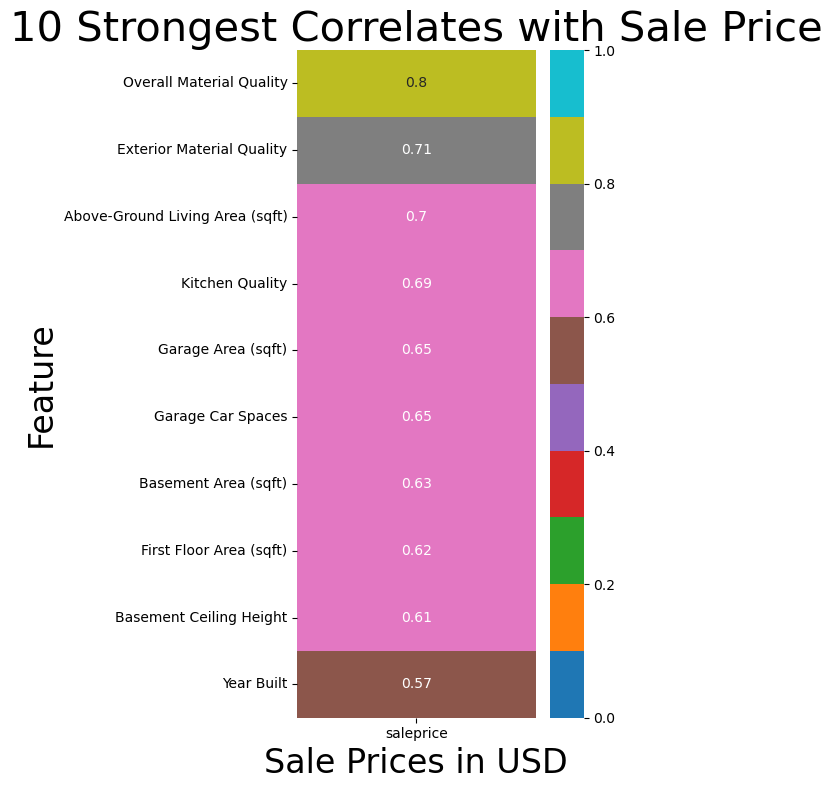

In [377]:
# Make a list of the variable names, in normal English
top10 = ['Overall Material Quality', 'Exterior Material Quality', 
 'Above-Ground Living Area (sqft)', 'Kitchen Quality', 'Garage Area (sqft)', 
 'Garage Car Spaces', 'Basement Area (sqft)', 'First Floor Area (sqft)', 
 'Basement Ceiling Height', 'Year Built']

plt.figure(figsize = (6, 8))
sns.heatmap(corrs[['saleprice']].sort_values(by = 'saleprice', ascending = False)[
            1:11], vmin = 0, vmax = 1, annot = True, cmap = 'tab10', 
            yticklabels = top10);
plt.title('10 Strongest Correlates with Sale Price', size = 30)
plt.xlabel('Sale Prices in USD', size = 24);
plt.ylabel('Feature', size = 24);
#plt.xticks(ticks = list(range(0, 600_001, 50_000)), size = 16, rotation = 60)
#plt.yticks(ticks = None, labels = top10, size = 16)
plt.tight_layout()
plt.savefig('./images/ten-best-correlates-heatmap.png')

As shown, most of these predictors have to do with the size in square feet of various elements of the home, or with its semi-subjective quality ranking.  In 10th place is the year it was built, which I suspect has more to do with its age than its vintage.  These are all perfectly reasonable things for homebuyers to prioritize, but they do present a problem for my models, particularly the inferential ones.  In order to work properly, models with multiple predictor variables require that those predictors not be overly correlated with each other, also known as multicolinear.  For obvious reasons, different measures of square footage within the same house are likely to be multicolinear.  The rule about multicolinearity can usually be bent a bit when the only purpose of the model is to make predictions, and hopefully that will be the case in my work here.  However, interpreting these models requires looking at each feature in isolation - holding all else constant.  When the features are correlated with each other, it is not possible to hold all else constant, and the interpretation becomes meaningless.  This may make it challenging to find a model that explains enough of the variance to be useful, while also being interpretable. If all else fails, I can create simple linear regressions with only one predictor, and see what can be gleaned from that.

## Modeling

In [378]:
# Define a function to give handy statistics efficiently
def sumstats(m, y, yhat, k):
  '''
  Return the summary stats for a given model in a dictionary.
  
  m: string, model number. can also be "m#-test" or "m#-train" to specify
  y: relevant y vector
  yhat: predicted values of y from the model
  k: number of predictors in the model
  '''
  rmse = metrics.mean_squared_error(y, yhat, squared = False)  
  r2 = metrics.r2_score(y, yhat)
  mse = metrics.mean_squared_error(y, yhat)
  mae = metrics.mean_absolute_error(y, yhat)
  r2adj = 1 - (((1-r2)*(len(y)-1))/(len(y)-k-1))
  resids = y - yhat
  null_resids = y_test - y.mean()
  null_mse = ((null_resids**2).sum())/len(y)
  null_rmse = (((null_resids**2).sum())/len(y))**(1/2)
  
  sumstats_dict = {'model': m, 'rmse': rmse, 'r2': r2, 
  'mse': mse, 'mae': mae, 'r2adj': r2adj, 'null_rmse': null_rmse, 
  'null_mse': null_mse, #'yhat': list(yhat), 'resids': list(resids), 
                  }
  
  print(f'MAE is {metrics.mean_absolute_error(y, yhat)}')
  print(f'MSE is {metrics.mean_squared_error(y, yhat)}')
  print(f'RMSE is {metrics.mean_squared_error(y, yhat, squared = False)}')
  print(f'R2 is {metrics.r2_score(y, yhat)}')
  print(f'R2adj is {1 - (((1-metrics.r2_score(y, yhat))*(len(y)-1))/(len(y)-k-1))}')
  
  return sumstats_dict

### OLS Regression

For a first attempt, I fit an OLS regression using all of the predictor variables to estimate the sale prices.  Although unlikely to be good model, this will give me a good idea of where I am starting.

In [385]:
X_train.shape

(1538, 229)

In [386]:
# OLS Model A
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)
mA_cvs = cross_val_score(lr, X_train, y_train)
mA_mean_cvs = mA_cvs.mean()
mAsumstats = sumstats('mA', y_test, lr.predict(X_test), len(X_test.columns))
print(f"Training R2: {lr.score(X_train, y_train)}")
print(mA_cvs)
print(mA_mean_cvs)
mAsumstats

MAE is 16771.621061123402
MSE is 531436452.7296908
RMSE is 23052.905516001465
R2 is 0.9169113881110793
R2adj is 0.8496771403281718
Training R2: 0.9283463129466145
[-1.45554390e+21 -2.26932177e+21 -2.59628135e+17 -2.21998845e+20
 -9.49859359e+19]
-8.084220158304817e+20


{'model': 'mA',
 'rmse': 23052.905516001465,
 'r2': 0.9169113881110793,
 'mse': 531436452.7296908,
 'mae': 16771.621061123402,
 'r2adj': 0.8496771403281718,
 'null_rmse': 79975.12333736739,
 'null_mse': 6396020352.8271265}

This model has very respectable $R^2$ statistics across the training and testing data, but $R^2$ can be deceiving.  Despite a seemingly good performance on the two sets, the cross validation scores betray the truth: those $R^2$ scores are negative, and well into billions of billions.  That is not technically supposed to be possible, but it makes a point.  Regardless of whatever happy accident caused my testing $R^2$ score to be so high, dramatic declines in performance like that when shifting from known to unknown data indicate high variance, or overfitting.  It is likely that the plethora of predictors - 229, more than 1 predictor per every 7 observations - are allowing the model to fit itself by essentially "memorizing the answers" to which predictors in the training data correspond to which prices.  When asked to make genuine predictions about X values it has not been trained on, the model is unable to do it.  

Given this problem, it is a bit odd that the testing $R^2$ is not lower.  I can only conclude that my train/test split divided my data in a fortuitous way, with similar patterns on both sides of the divide allowing the model to coast.  However, the fact that the internal shuffling of cross validation sends it to ruin, makes its problems very evident.

On the positive side, it is worth noting is the null RMSE: \$79,975.12.  That is the average distance between the predicted value and the actual value (plus and minus some squaring), if the predicted value was always the mean.  That is the value to beat - and, even in this catastrophic model, I have beaten it!  The RMSE of my model is "only" \$23,052.91 - approximately one third of the null RMSE.  (Although I don't recommend that any of my realtor clients try to explain an additional \$23k cost to any of their buyers with the word "only!")

For the next attempt, I am using those 10 highly correlated predicted identified above.  As discussed there, these predictors are likely too correlated with each other for a model containing all of them to be interpretable, but it may have predictive utility.  Reducing the number of predictors, in and of itself, may also help ease the overfitting seen above.

In [400]:
mB = corrs_in_order[:11]

# OLS Model B
lr = LinearRegression()
lr.fit(X_train[mB], y_train)
lr.score(X_train[mB], y_train)
mB_cvs = cross_val_score(lr, X_train[mB], y_train)
mB_mean_cvs = mB_cvs.mean()
mBsumstats = sumstats('mB', y_test, lr.predict(X_test[mB]), len(X_test[mB].columns))
print(f"Training R2: {lr.score(X_train[mB], y_train)}")
print(mB_cvs)
print(mB_mean_cvs)
mBsumstats

MAE is 22176.128195175417
MSE is 969468168.8957638
RMSE is 31136.283800347206
R2 is 0.8484263471007802
R2adj is 0.8450983826658672
Training R2: 0.7944642281051422
[0.69699151 0.80363566 0.83582116 0.83924743 0.71816259]
0.7787716720273823


{'model': 'mB',
 'rmse': 31136.283800347206,
 'r2': 0.8484263471007802,
 'mse': 969468168.8957638,
 'mae': 22176.128195175417,
 'r2adj': 0.8450983826658672,
 'null_rmse': 79975.12333736739,
 'null_mse': 6396020352.8271265}

Using significantly fewer predictors did not ease the overfitting.  In fact, it seems to be worse.  The same pattern appeared again where the testing $R^2$ remained relatively high, albeit not as high as before, while the cross validation scores reveal deeper problems.  Perhaps worst of all, the RMSE went up, now sitting at \$31,136.28.  Although still significantly better than the null RMSE (which is constant, regardless of the model), I cannot imagine that my realtor clients or their clients would be happy increasing their unknown costs by nearly \$10,000.

In my background work, I fit and tested 9 OLS models, none of which produced remarkable results.  The model above is representative of about as good at got.  Therefore, I am going to skip directly to the regularized models, which employ anti-variance measures to reduce the overfitting seen in these simple OLS models.

### LASSO Regression

LASSO regression is the method I am most optimistic about.  LASSO is famous for taking in huge numbers of predictors and whittling them down to only the ones that "pull their weight."  Unlike OLS, which is calculated purely based on the relationship of the predictors to the target, LASSO regression (and Ridge, which we will see next), adds a "penalty term" for each additional variable in the model.  The equation is then optimized to produce the minimum possible sum of the Mean Squared Error (MSE - a precursor to RMSE; the average error per observation, squared and summed) and the penalty term.  Any predictor that cannot add enough predictive power to reduce MSE by more than its value adds to the penalty term, is driven to zero in the process, effectively removing it from the model.  

As part of the model fitting process, it is necessary to provide a list of potential multipliers to use in the penalty term.  The LASSO model within Scikit-learn then iterates over these multipliers, conducts cross-validation tests while fitting a model on X_train and y_train, and automatically selected the combination of parameters that produce the best $R^2$ score.

Because not all values of alpha will converge on a set of best parameters, using this function produces a great number of warning messages.  To avoid cluttering the report more than is strictly necessary, I have commented out the iterating code, and replaced it with 1, the optimal alpha found during cross-validation.

In [412]:
### LASSO 2 ###

# This code is commented out to save time and space in the output.
# The optimal alpha it finds is 1.
# Set up the alphas to test
#l2_alphas = np.linspace(0,1,100)
#lasso2_cv = LassoCV(alphas = l2_alphas)

lasso2_cv = LassoCV(alphas = [1])
lasso2_cv.fit(X_train, y_train)
lasso2_cv.alpha_ 
print(f"Training R2: {lasso2_cv.score(X_train, y_train)}")
print(f"Testing R2: {lasso2_cv.score(X_test, y_test)}")
yhat = lasso2_cv.predict(X_test)
lasso2sumstats = sumstats('lasso2', y_test, yhat, len(X_test.columns))
print(f"Optimal alpha: {lasso2_cv.alpha_}")
lasso2sumstats

C:\Users\emily\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161685696088.05392, tolerance: 767871890.5525268
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\emily\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 149985328218.32278, tolerance: 742643148.695578
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\emily\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 156451943219.48877, tolerance: 725467859.9201217
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\emily\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: 

Training R2: 0.9303600679315743
Testing R2: 0.9194696027855722
MAE is 16341.238163406922
MSE is 515074059.6047332
RMSE is 22695.243105213332
R2 is 0.9194696027855722
R2adj is 0.8543054297746041
Optimal alpha: 1


C:\Users\emily\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.070e+11, tolerance: 9.597e+08
  model = cd_fast.enet_coordinate_descent(


{'model': 'lasso2',
 'rmse': 22695.243105213332,
 'r2': 0.9194696027855722,
 'mse': 515074059.6047332,
 'mae': 16341.238163406922,
 'r2adj': 0.8543054297746041,
 'null_rmse': 79975.12333736739,
 'null_mse': 6396020352.8271265}

Although $R^2$ is not dramatically greater than it was in the OLS models, RMSE has been reduced.  Additionally, because LASSO regression eliminates unhelpful predictors from the model, I am more inclined to trust these $R^2$ scores than the ones from OLS.

Keen readers may notice that the alpha the model determined to be best, 1, was the maximum possible alpha it had available.  Similarly to OLS, I fit many of these models in my background work, but do not see any purpose in boring the reader with all of them here.  Suffice to say, I allowed them to test alphas up to 100.  Overall, the model picked approximately 49.2 as its optimal alpha.  However, when penalty hyperparameters get too high, they can cause the model to sacrifice predictive power in favor of conistency across seen and unseen data.  Allowing the model to fit using an alpha of 5, 10, 48, 49.2, or any of the other values it settled on netted only modest gains in $R^2$, and sacrificed the improved RMSE score in the process.  OLS models had RMSEs hovering around \$23,000, the LASSO regression above with alpha = 1 brought that down to about \$22,000, and the models with alphas around 49 drove it up to \$24,000.  I assumed that my clients would prefer to be able to say to their clients, "this thing can get us within \$22,000 (as opposed to \$24,000)," rather than "this thing can explain the same amount of variance, within 0.03 percentage points, on seen and unseen data."  With all of the values so close together, and none of them quite where I had hoped they would be, I erred on the side of producing something more utilitarian.

### Ridge Regression

The final type of model I will explore is a Ridge regression.  This is very similar to LASSO, but less aggressive.  It will not fully 0-out any predictors, and therefore, I suspect I will suffer from slightly more overfitting than the LASSO model did.  The setup in the code is similar.

In [413]:
# Ridge Model 1
r_alphas1 = (np.linspace(0, 50, 101))[1:]
ridge1_cv = RidgeCV(alphas = r_alphas1, cv = 5)
ridge1_cv.fit(X_train, y_train)
print(f'Training R2: {ridge1_cv.score(X_train, y_train)}')
print(f'Testing R2: {ridge1_cv.score(X_test, y_test)}')
print(f"Optimal alpha: {ridge1_cv.alpha_}")
yhat = ridge1_cv.predict(X_test)
ridge1sumstats = sumstats('ridge 1', y_test, yhat, len(X_test.columns))
ridge1sumstats

Training R2: 0.9015836543328245
Testing R2: 0.9012379281045604
Optimal alpha: 5.0
MAE is 17372.219995290252
MSE is 631684221.9306079
RMSE is 25133.32890666511
R2 is 0.9012379281045604
R2adj is 0.821320915864081


{'model': 'ridge 1',
 'rmse': 25133.32890666511,
 'r2': 0.9012379281045604,
 'mse': 631684221.9306079,
 'mae': 17372.219995290252,
 'r2adj': 0.821320915864081,
 'null_rmse': 79975.12333736739,
 'null_mse': 6396020352.8271265}

As with the other types of models, I fit several Ridge regressions, and will spare readers the gory - and frankly, very repetitive(!) - details.  The Ridge model does not suffer from as much overfitting as I had feared, but it does not seem gain anything either.  It produces very consist $R^2$ scores across training and testing sets, but they are not any higher than the LASSO ones.  RMSE, however, is higher.  

Ridge models usually require higher alphas than LASSO models, so I allowed this one to test up to 100 in the very first try, and it settled on 5.  In followup trials I allowed it to try hundreds of decimal values between 5 and 6, and it never found a better alpha.

I have listed below some ideas for improving this model in the future, but for now, the best I can offer is a simple linear regression of the highest correlated feature within a 

## Conclusions

Based on the models I tested, I conclude that the LASSO model with alpha 1 is the best for prediction.  It does not get as close to the true values as I had hoped it would (*RMSE* = \\\$22,695.24), but it does eliminate two thirds of the error present in the null model (nearly \\\$80k!).  These results were consistent across cross validation trials, and when applied to the data on the unseen side of the train/test split.  Its $R^2$ scores are in the high 90s, (0.93 and 0.92 for the training and testing data, respectively), meaning it can explain approximately 92% of the variance in home prices.  Although I am sure there is more that I can do to even further improve upon this model (see below), I think this is a positive first step that will prove useful for my clients.

Unfortunately, the plagues of mutlicolinearity and overfitting greatly hampered my ability to fit an interpretable OLS.  I have ideas listed below to address this in future work, but my secondary goal of providing actionable insights to homeowners looking to increase their resale values cannot be met at this time.

As for my primary goal, providing a predictive model to realtors, I am satisfied with the LASSO model fit above.  I am ready to deploy it to my clients at their convenience, and feel confident that it can provide useful predictions for them on how much a house is likely to sell for.  My only cautions, as mentioned in earlier sections, are to avoid relying too heavily on the lot frontage predictor (because it had a great deal of missing values), or on any predictions greater than about \$325,000.

#### Recommendations for future work

- Continue adjusting the predictors in hopes of identifying higher performing models.  Many categorical variables had only a handful of observations in some levels, yet all levels were converted to their own columns.  It may be more useful to combine some of the smaller levels.
- Attempt polynomial features again.  I did attempt, for the current work, to include polynomial and interaction terms, but my current equipment could not handle the burden.  Perhaps if, as I hope, the model I came up with proves useful to my clients, they will invest in me with more powerful tools.

If the model is interpretable, do so.  If not, explain why not.